In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from ignite.metrics import FID, InceptionScore
from ignite.engine import Engine
import PIL.Image as Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(nn.ConvTranspose2d(latent_size, 512, 4, stride=1, padding=0, bias=False),
                                 nn.BatchNorm2d(512),
                                 nn.ReLU(True),
                                 nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False),
                                 nn.BatchNorm2d(256),
                                 nn.ReLU(True),
                                 nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
                                 nn.BatchNorm2d(128),
                                 nn.ReLU(True),
                                 nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
                                 nn.BatchNorm2d(64),
                                 nn.ReLU(True),
                                 nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias=False),
                                 nn.BatchNorm2d(32),
                                 nn.ReLU(True),
                                 nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1, bias=False),
                                 nn.Tanh())

    def forward(self, x):
        x = x.view(x.size(0), latent_size, 1, 1)
        return self.gen(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(nn.Conv2d(3, 32, 3, stride=1, padding=1, bias=False),
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.Conv2d(32, 64, 4, stride=2, padding=1, bias=False),
                                  nn.BatchNorm2d(64),
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
                                  nn.BatchNorm2d(128),
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
                                  nn.BatchNorm2d(256),
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
                                  nn.BatchNorm2d(512),
                                  nn.LeakyReLU(0.2, inplace=True),
                                  nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
                                  nn.Sigmoid())

    def forward(self, x):
        return self.disc(x)

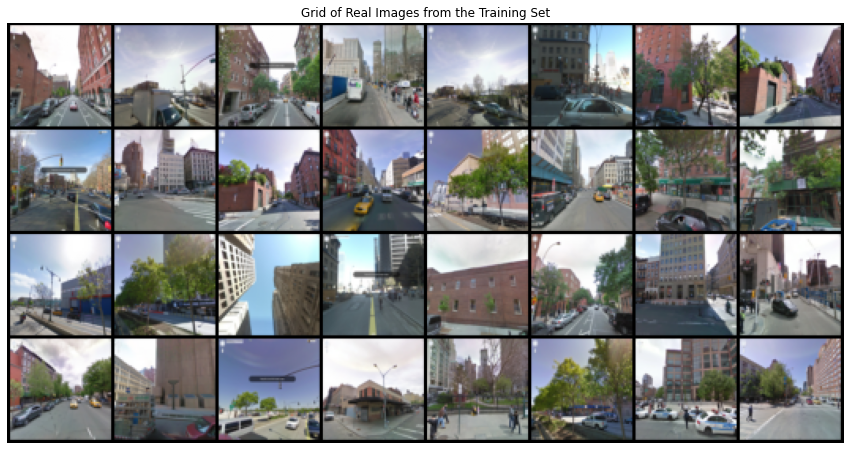

In [ ]:
latent_size = 100
num_epochs = 150
batch_size = 32
learning_rate = 0.0005

transform=T.Compose([T.Resize((64,64)),
                     T.ToTensor(),
                     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.ImageFolder('./city/train',transform=transform)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)

def check_input(img):
    img = img / 2 + 0.5
    plt.figure(figsize=(15,15))
    grid = torchvision.utils.make_grid(img, ncol=8)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title('Grid of Real Images from the Training Set')
    plt.show()
img,lab=next(iter(train_loader))
check_input(img)

In [ ]:
gen = Generator().to(device)
disc = Discriminator().to(device)

gen.apply(weights_init)
disc.apply(weights_init)

loss = nn.BCELoss()

optimizer_g = optim.Adam(gen.parameters(), lr=0.0005, betas=(0.5, 0.999))
optimizer_d = optim.Adam(disc.parameters(), lr=0.0005, betas=(0.5, 0.999))

finald=[]
finalg=[]

total_step = len(train_loader)
for epoch in range(num_epochs):
    for t, (real_images, y) in enumerate(train_loader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        disc.zero_grad()
        outputs = disc(real_images)
        real_loss = loss(outputs, torch.ones_like(outputs))
        z = torch.randn(batch_size, latent_size, 1, 1).to(device)
        fake_images = gen(z)
        outputs = disc(fake_images.detach())
        fake_loss = loss(outputs, torch.zeros_like(outputs))
        d_loss = real_loss + fake_loss
        d_loss.backward(retain_graph=True)
        optimizer_d.step()

        gen.zero_grad()
        outputs = disc(fake_images)
        g_loss = loss(outputs, torch.ones_like(outputs))
        g_loss.backward()
        optimizer_g.step()

        if (t + 1) % 67 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'
                  .format(epoch+1, num_epochs, t + 1, total_step, d_loss.item(), g_loss.item()))

        finald.append(d_loss.item())
        finalg.append(g_loss.item())

Epoch [1/150], Step [67/67], d_loss: 0.9621, g_loss: 4.3990
Epoch [2/150], Step [67/67], d_loss: 0.3878, g_loss: 5.6167
Epoch [3/150], Step [67/67], d_loss: 0.4906, g_loss: 3.4810
Epoch [4/150], Step [67/67], d_loss: 0.8433, g_loss: 2.0029
Epoch [5/150], Step [67/67], d_loss: 0.7808, g_loss: 4.1000
Epoch [6/150], Step [67/67], d_loss: 1.2884, g_loss: 2.7607
Epoch [7/150], Step [67/67], d_loss: 1.3570, g_loss: 1.7576
Epoch [8/150], Step [67/67], d_loss: 0.9095, g_loss: 2.4522
Epoch [9/150], Step [67/67], d_loss: 0.8102, g_loss: 3.0419
Epoch [10/150], Step [67/67], d_loss: 0.4974, g_loss: 4.1087
Epoch [11/150], Step [67/67], d_loss: 0.6409, g_loss: 4.1185
Epoch [12/150], Step [67/67], d_loss: 0.4615, g_loss: 3.7121
Epoch [13/150], Step [67/67], d_loss: 0.9241, g_loss: 2.7552
Epoch [14/150], Step [67/67], d_loss: 0.6272, g_loss: 2.9900
Epoch [15/150], Step [67/67], d_loss: 1.1233, g_loss: 5.2215
Epoch [16/150], Step [67/67], d_loss: 0.9156, g_loss: 4.2299
Epoch [17/150], Step [67/67], d_l

torch.Size([16, 3, 64, 64])


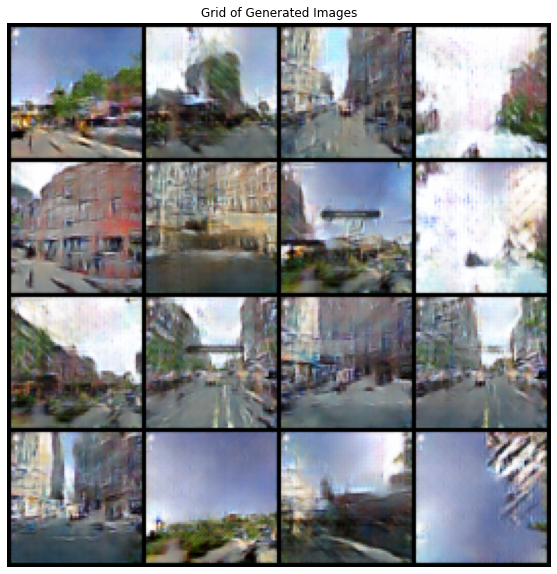

In [ ]:
from torchvision.utils import make_grid

sample_z = torch.randn(16, latent_size, 1, 1).to(device)
sample_generated_images = gen(sample_z)
print(sample_generated_images.shape)
generated = sample_generated_images.detach().cpu()
plt.figure(figsize = (10,10))
sample_grid = make_grid(generated, nrow=4, normalize=True)
plt.imshow(np.transpose(sample_grid, (1, 2, 0)))
plt.axis('off')
plt.title('Grid of Generated Images')
plt.show()

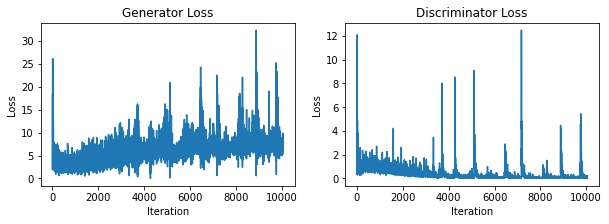

In [ ]:
plt.figure(figsize=(10,3))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(finalg)
plt.title('Generator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
ax2=plt.subplot(1, 2, 2)
ax2.plot(finald)
plt.title('Discriminator Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

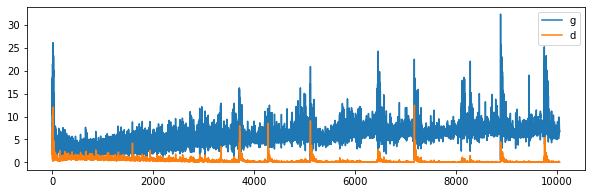

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(finalg,label='g')
plt.plot(finald,label='d')
plt.legend()
plt.show()

In [ ]:
test_batch_size=13

test_dataset = datasets.ImageFolder('./city/test',transform=transform)
test_loader = DataLoader(test_dataset, test_batch_size, shuffle=True, num_workers=2)

def sample_images():
    gen.eval()
    with torch.no_grad():
        z = torch.randn(test_batch_size, latent_size, 1, 1).to(device)
        generated_images = gen(z)
    return generated_images
def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = T.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(T.ToTensor()(resized_img))
    return torch.stack(arr)
def get_fake():
    return sample_images()
def evaluation_step(engine, batch):
    with torch.no_grad():
        fake = get_fake()
        fake = interpolate(fake.cpu())
        real = interpolate(batch[0])
        return fake, real
fid_metric = FID(device=device)
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")
evaluator.run(test_loader, max_epochs=1)
metrics = evaluator.state.metrics
fid_score = metrics['fid']
is_score = metrics['is']


In [ ]:
print('fid_score: '+str(fid_score))
print('is_score: '+ str(is_score))

fid_score: 0.05271258931969805
is_score: 2.1482686740308843
